In [52]:
%matplotlib inline
import random
import numpy as np
import networkx as nx
from cascade import generate_cascade_old
from simulations import simulate_IC
from ic import sample_graph_from_infection, make_partial_cascade, make_full_cascade
from graph_generator import grid_2d, add_p_and_delta
from tqdm import tqdm

In [30]:
g = grid_2d(10)
g = add_p_and_delta(g, p=0.7, d=1)

In [31]:
induced_g = sample_graph_from_infection(g)

In [32]:
induced_g.number_of_edges() / g.number_of_edges()

0.7444444444444445

In [33]:
es1 = set(map(lambda e: tuple(sorted(e)), g.edges()))
es2 = set(map(lambda e: tuple(sorted(e)), induced_g.edges()))

In [34]:
assert es2.issubset(es1)

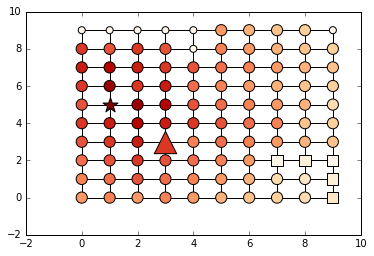

In [35]:
from utils import infeciton_time2weight
from plot_utils import plot_snapshot
pos = {n: np.array(n) for n in g.nodes()}

source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.05, sampling_method='late_nodes')

node2weight = infeciton_time2weight(infection_times)

plot_snapshot(g, pos, node2weight, 
              query_node=(3, 3),
              source_node=source,
              queried_nodes=obs_nodes, 
              max_node_size=500)

In [36]:
infection_times =  make_full_cascade(g, source=(5, 5))
assert infection_times[(5, 5)] == 0

In [37]:
infection_times = make_full_cascade(induced_g, source=(5, 5), is_sampled=True)

In [38]:
expected = nx.shortest_path_length(induced_g, source=(5, 5), weight='d')
actual = infection_times
for n, t in expected.items():
    assert t == actual[n]

In [39]:
%%timeit
make_full_cascade(g)

1000 loops, best of 3: 1.09 ms per loop


In [40]:
%%timeit
generate_cascade_old(g)

100 loops, best of 3: 4.01 ms per loop


In [41]:
%%timeit 
simulate_IC(g)

100 loops, best of 3: 2.16 ms per loop


In [42]:
%%timeit 
make_partial_cascade(g, 0.05, 'late_nodes')

1000 loops, best of 3: 1.38 ms per loop


In [43]:
len(nx.shortest_path_length(induced_g)[(0, 1)])

97

In [48]:
from scipy.stats import hmean
from collections import defaultdict
from joblib import Parallel, delayed
def infection_time_estimation(g, n_rounds, mean_method='harmonic'):
    """
    estimate the harmonic mean of infection times given each node as source

    Returns:
    dict source to nodes' infection time:
    for each node as source, return the estimated infection times of all nodes
    """
    sampled_graphs = [sample_graph_from_infection(g)
                      for i in range(n_rounds)]
    s2t_len_list = Parallel(n_jobs=-1)(
        delayed(nx.shortest_path_length)(g, weight='d')
        for g in sampled_graphs)
    # 3D array
    s2n_times = defaultdict(lambda: defaultdict(list))

    for g, s2t_len in tqdm(zip(sampled_graphs, s2t_len_list)):
        for s in s2t_len:
            for n in g.nodes_iter():
                s2n_times[s][n].append(s2t_len[s].get(n, float('inf')))

    est = defaultdict(dict)
    if mean_method == 'harmonic':
        def mean_func(times):
            times = np.array(times)
            times = times[np.nonzero(times)]
            if times.shape[0] >	0:
                return hmean(times)
            else:
                return 0
    else:
        raise ValueError('{"harmoic"} accepted')

    for s, n2times in tqdm(s2n_times.items()):
        for n, times in n2times.items():
            est[s][n] = mean_func(times)
    return est, s2n_times

In [45]:
%%timeit 
est, s2n_times = infection_time_estimation(g, n_rounds=100)

1 loop, best of 3: 3.18 s per loop


In [46]:
from synthetic_data import gen_kronecker
from graph_generator import P_hier
g = gen_kronecker(P_hier, k=10, n_edges=2048)
g = add_p_and_delta(g, 0.7, 1)

In [49]:
print(g.number_of_nodes())
print(g.number_of_edges())

956
1968


In [50]:
%%timeit 
est, s2n_times = infection_time_estimation(g, n_rounds=100)

100it [01:10,  1.58it/s]
100%|██████████| 956/956 [00:42<00:00, 22.38it/s]
100it [01:11,  1.43it/s]
100%|██████████| 956/956 [00:42<00:00, 17.37it/s]
100it [01:10,  1.57it/s]
100%|██████████| 956/956 [00:41<00:00, 23.04it/s]
100it [01:10,  1.43it/s]
100%|██████████| 956/956 [00:44<00:00, 21.68it/s]


1 loop, best of 3: 2min 36s per loop
